In [56]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import equinox as eqx
from jax import random
from jax.random import PRNGKey, split
from jax import jit, grad
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle

import seaborn as sns

from sklearn.model_selection import train_test_split
from dysts.flows import Lorenz, Rossler


In [57]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='icefire', font='serif',
            font_scale=1, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [58]:
# jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')

In [59]:
# | export

class Model(eqx.Module):
    layers: list

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.tanh(layer(x))
        return self.layers[-1](x)

In [60]:
# | export

def MLP(layer_sizes, key):
    keys = split(key, len(layer_sizes) - 1)
    layers = [
        eqx.nn.Linear(in_size, out_size, key=k)
        for in_size, out_size, k in zip(layer_sizes[:-1], layer_sizes[1:], keys)
    ]
    return Model(layers)

In [61]:
# | export

@eqx.filter_value_and_grad()
def compute_loss(params, x, y):
    preds = jax.vmap(params)(x)
    mse = jnp.mean((preds - y) ** 2)
    nrmse = jnp.sqrt(mse) / jnp.std(y)
    return mse

In [62]:
# | export

@eqx.filter_jit
def train_step(params, x, y, opt_state, opt_update):
    loss, grads = compute_loss(params, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    params = eqx.apply_updates(params, updates)
    return loss, params, opt_state

In [63]:
# Compute the gradient norm
def grad_norm(grads):
    return jnp.sqrt(sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(grads)))


In [64]:
input_size = 2
hidden_sizes = [128, 128] 
output_size = 1
num_epochs = 25000
intervene_every = 50
seed = 0
threshold = 1e-4
grad_norm_threshold = 1e-3
n_samples = 20000
test_size = 0.2
learning_rate = 3e-4

In [65]:
model = Lorenz()
lorenz = model.make_trajectory(n_samples, resample=True)
x = jnp.array(lorenz[:, 1:])
y = jnp.array(lorenz[:, 0])

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

Text(0.5, 0.98, 'Data')

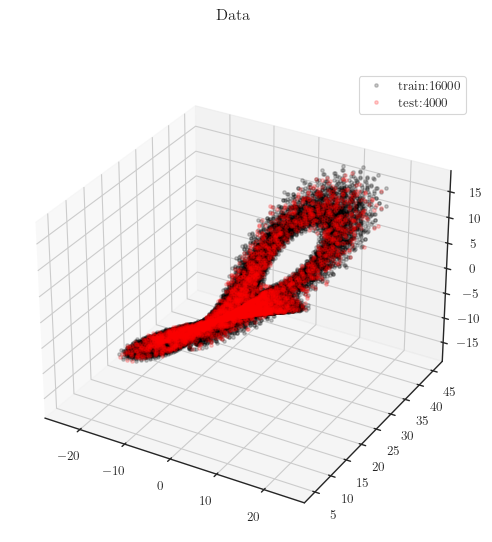

In [67]:
plt.figure(figsize=(6,6)).add_subplot(projection='3d')
plt.plot(x_train[:,0], x_train[:,1], y_train, "k.", alpha=0.2, label=f"train:{len(x_train)}")
plt.plot(x_test[:,0], x_test[:,1], y_test, "r.", alpha = 0.2, label=f"test:{len(x_test)}")
plt.legend()
plt.suptitle("Data")

In [68]:
# Main training function
def train_mlp(num_epochs=1000, learning_rate=3e-4):
    key = random.PRNGKey(0)
    layer_sizes = [2, 128, 128, 1]  # Input layer, two hidden layers, and output layer
    model = MLP(layer_sizes, key)
    opt = optax.adam(learning_rate)
    opt_state = opt.init(model)
    loss_history = []

    # Training loop
    for epoch in range(num_epochs):
        loss, model, opt_state = train_step(model, x_train, y_train, opt_state, opt.update)
        _, grads  = compute_loss(model, x_train, y_train)
        grad_norm_val = grad_norm(grads)
        loss_history.append(loss)
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}, Loss: {loss}, Grad norm: {grad_norm_val}')

    return model, loss_history


In [69]:
model, loss_history = train_mlp(num_epochs=25000)
n_nodes = model.layers[0].in_features + sum([layer.out_features for layer in model.layers]) 
node_history = [n_nodes] * len(loss_history)

Epoch 100, Loss: 62.75030517578125, Grad norm: 0.03614450618624687
Epoch 200, Loss: 62.750118255615234, Grad norm: 0.005121574271470308
Epoch 300, Loss: 62.750057220458984, Grad norm: 0.0027532754465937614
Epoch 400, Loss: 62.75002670288086, Grad norm: 0.0016464298823848367
Epoch 500, Loss: 62.75001525878906, Grad norm: 0.0011355567257851362
Epoch 600, Loss: 62.75000762939453, Grad norm: 0.0008623747271485627
Epoch 700, Loss: 62.75, Grad norm: 0.0006989466492086649
Epoch 800, Loss: 62.75, Grad norm: 0.000584254739806056
Epoch 900, Loss: 62.75, Grad norm: 0.0004983781836926937
Epoch 1000, Loss: 62.74999237060547, Grad norm: 0.00043161612120456994
Epoch 1100, Loss: 62.74999237060547, Grad norm: 0.00037892351974733174
Epoch 1200, Loss: 62.74999237060547, Grad norm: 0.0003382079303264618
Epoch 1300, Loss: 62.74999237060547, Grad norm: 0.00030657771276310086
Epoch 1400, Loss: 62.74999237060547, Grad norm: 0.0002762907824944705
Epoch 1500, Loss: 62.74999237060547, Grad norm: 0.00024547788780

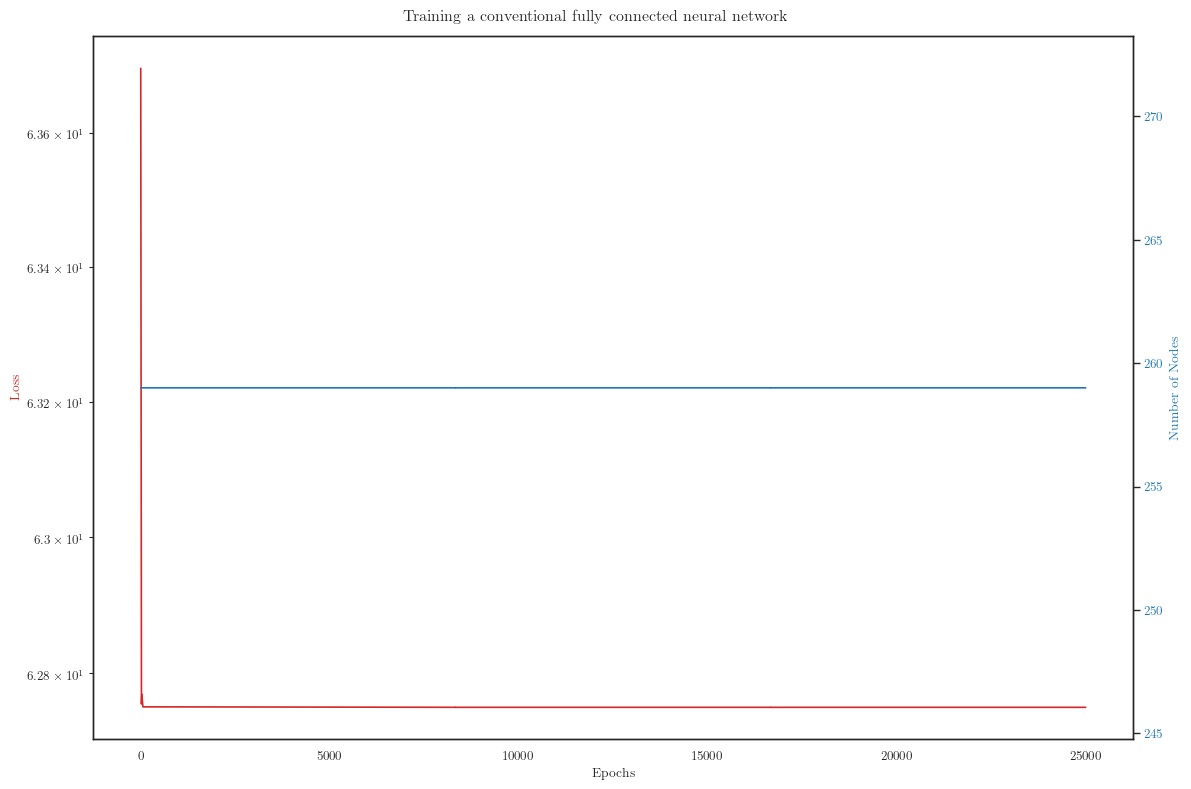

In [70]:
fig, ax1 = plt.subplots(figsize=(12, 8))
num_epochs = len(loss_history)
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,num_epochs), loss_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,num_epochs), node_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Training a conventional fully connected neural network")
fig.tight_layout()

In [71]:
y_pred = jax.vmap(model)(x_test)

In [72]:
# Plot the results
def plot_results(x, y_true, y_pred):
    plt.axes().set_aspect('equal')
    plt.plot(x, y_true, "." ,label='True sin(x)')
    plt.plot(x, y_pred, "." ,label='Predicted sin(x)')
    
    plt.legend()
    plt.show()

Text(0.5, 0.92, 'MLP Approximation of the Lorenz Attractor')

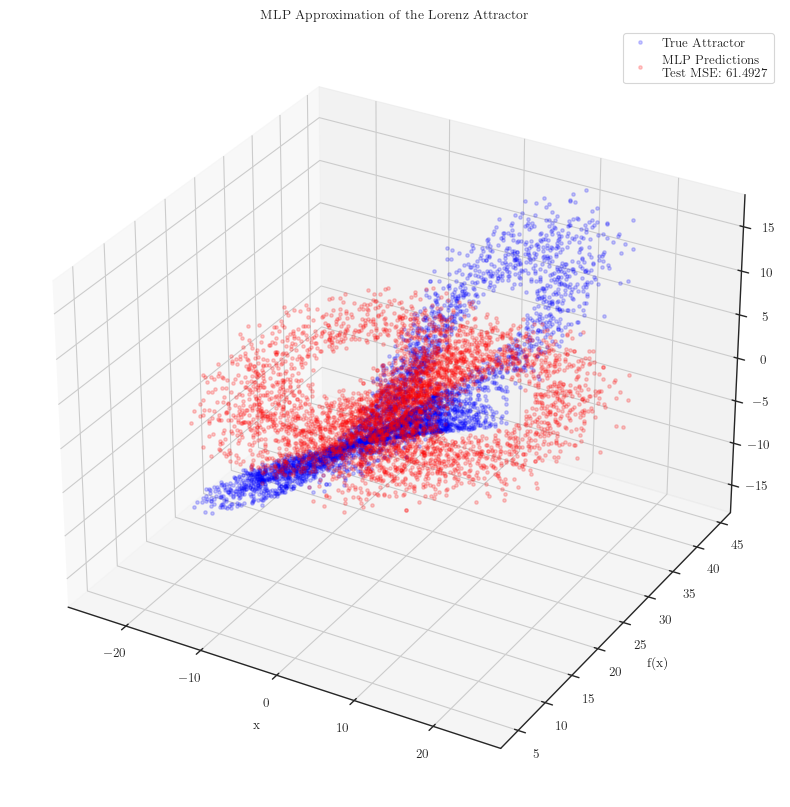

In [73]:
test_mse = jnp.mean((y_pred - y_test) ** 2)
plt.figure(figsize=(10,10)).add_subplot(projection='3d')
plt.plot(x_test[:,0], x_test[:,1], y_test, "b.", alpha = 0.2, label="True Attractor")
plt.plot(x_test[:,0], x_test[:,1], y_pred[:,0], "r.", alpha = 0.2, label="MLP Predictions\n Test MSE: {:.4f}".format(test_mse))
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("MLP Approximation of the Lorenz Attractor")